In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tau_classification/')

from base import *
from constants import *
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tuning_parameters/')

from tuning import * 
from extra_metrics_training import *
from tuning_constants import * 

In [2]:
import joblib

In [3]:
import pandas as pd
import numpy as np 
import random 

from sklearn import preprocessing 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [4]:
path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tau_classification/Untrained/Training_data/DN/"
filename = "training.txt"

# Create tau database object 
dn_data = TauDataBase(path = path,
                      filename = filename) 

# Prepping data to train tau classifier for dentate nucleus
dn_data.classifier2_prep()

# Check data
print(dn_data.c2_data['Class'].value_counts())
print(dn_data.c2_X_train.shape)

Others    1805
NFT        234
CB         147
Name: Class, dtype: int64
(2186, 54)


In [6]:
# Tuning 
rf_random = RandomizedSearchCV(pipeline,
                               param_distributions=random_grid, 
                               n_iter=100,
                               cv=10,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1,
                               refit='PR_AUC',
                               scoring={
                                'PR_AUC':precision_recall_auc_tau_noTA,
                                'roc_auc_ovr_weighted':'roc_auc_ovr_weighted',
                                'roc_auc_ovo':'roc_auc_ovo',
                                'balanced_accuracy':'balanced_accuracy',
                                'f1_weighted':'f1_weighted',
                                'CB_accuracy': CB_acc_noTA,
                                'NFT_accuracy':NFT_acc_noTA,
                                'Others_accuracy':Others_acc_noTA
                                        })

rf_random.fit(dn_data.c2_X_train,
              dn_data.c2_Y_train)


print(rf_random.best_score_)
print(rf_random.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0.9796589612447606
{'selector__n_features_to_select': 34, 'clf__sampling_strategy': 'not majority', 'clf__random_state': 42, 'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_samples': None, 'clf__max_features': 0.2, 'clf__max_depth': None, 'clf__class_weight': 'balanced'}


In [7]:
# Digging into more details 
print("PR-AUC:",
      rf_random.cv_results_['mean_test_PR_AUC'][rf_random.best_index_]*100)
print("ROC-AUC:",
      rf_random.cv_results_['mean_test_roc_auc_ovr_weighted'][rf_random.best_index_]*100)
print("ROC-AUC:",
      rf_random.cv_results_['mean_test_roc_auc_ovo'][rf_random.best_index_]*100)

print("Balanced accuracy:",
      rf_random.cv_results_['mean_test_balanced_accuracy'][rf_random.best_index_]*100)

print("F1_weighted:",
      rf_random.cv_results_['mean_test_f1_weighted'][rf_random.best_index_]*100)

print("CB accuracy:",
      rf_random.cv_results_['mean_test_CB_accuracy'][rf_random.best_index_]*100)

print("NFT accuracy:",
      rf_random.cv_results_['mean_test_NFT_accuracy'][rf_random.best_index_]*100)

print("Others accuracy:",
      rf_random.cv_results_['mean_test_Others_accuracy'][rf_random.best_index_]*100)

# print("Classified CB as NFT:",
#       rf_random.cv_results_['mean_test_CB_as_NFT'][rf_random.best_index_]*100)

# print("Classified CB as Others:",
#       rf_random.cv_results_['mean_test_CB_as_Others'][rf_random.best_index_]*100)

# print("Classified NFT as CB:",
#       rf_random.cv_results_['mean_test_NFT_as_CB'][rf_random.best_index_]*100)

# print("Classified NFT as Others:",
#       rf_random.cv_results_['mean_test_NFT_as_Others'][rf_random.best_index_]*100)

# print("Classified Others as CB:",
#       rf_random.cv_results_['mean_test_Others_as_CB'][rf_random.best_index_]*100)

# print("Classified Others as NFT:",
#       rf_random.cv_results_['mean_test_Others_as_NFT'][rf_random.best_index_]*100)

                                                       

PR-AUC: 97.96589612447606
ROC-AUC: 99.56778080589778
ROC-AUC: 99.32693861868286
Balanced accuracy: 93.03483287515236
F1_weighted: 97.97626221538805
CB accuracy: 85.0
NFT accuracy: 94.54710144927535
Others accuracy: 99.55739717618168


In [8]:
# save object using joblib
joblib.dump(rf_random, 'dn_random_search.sav')

['dn_random_search.sav']

{'selector__n_features_to_select': 34, 'clf__sampling_strategy': 'not majority', 'clf__random_state': 42, 'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_samples': None, 'clf__max_features': 0.2, 'clf__max_depth': None, 'clf__class_weight': 'balanced'}


In [5]:
dn_classifier_hyperparams = [
    ('normalizer', MinMaxScaler()),
    ('selector', RFE(RandomForestClassifier(
        random_state=42),
        n_features_to_select=34)),
    ('clf', BalancedRandomForestClassifier(
        random_state=42,
        sampling_strategy='not majority',
        n_estimators=100,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=0.2,
        max_depth=None,
        max_samples=None,
        class_weight='balanced'))]
        
# 10-fold cross validation
model = TauClassifierNoTATuning(hyperparameters=dn_classifier_hyperparams)
model.find_bestparameters(X=dn_data.c2_X_train,
                          Y=dn_data.c2_Y_train)


In [6]:
model.best_parameters

{0: (0.409, 0.9144010858386309, 0.9031204850361197, 0.9314285714285713),
 1: (0.422, 0.9811932262266609, 0.9714598662207358, 0.9916666666666668),
 2: (0.6599999999999999,
  0.9944717736676886,
  0.9934360958126922,
  0.9955770411295273)}

In [8]:
mean(model.pr_auc_validation)

0.9796589612447606

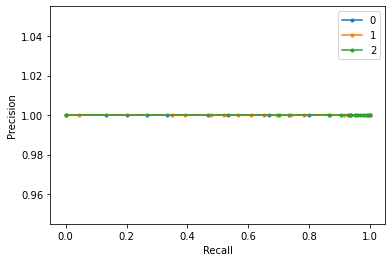

In [16]:
# from matplotlib import pyplot

# # plot the precision-recall curves
# pyplot.plot(model.recall[0], model.precision[0], marker='.', label='0')
# pyplot.plot(model.recall[1], model.precision[1], marker='.', label='1')
# pyplot.plot(model.recall[2], model.precision[2], marker='.', label='2')
# # axis labels
# pyplot.xlabel('Recall')
# pyplot.ylabel('Precision')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

In [9]:
model.cv_withthresholding(best_parameters=model.best_parameters,
                          X=dn_data.c2_X_train,
                          Y=dn_data.c2_Y_train,
                          X_location=dn_data.c2_train_location)


In [10]:
# Confusion matrix across 10 folds, WITH thresholding 
print('with thresholding (non-calibrated) ACC :', mean(model.cv_accuraciesT)*100)
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reportsT])*100)
print("--------------------------")
cf_t = sum(model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100
print(cf_t)
print(final_cm_t)
print("--------------------------")
print("CB accuracy",final_cm_t[0][0])
print("NFT accuracy",final_cm_t[1][1])
print("Others accuracy",final_cm_t[2][2])
print('------------------------------')
# F1-score per class: 
print('CB f1-score ',mean([i['CB']['f1-score'] for i in model.cv_reportsT])*100)
print('CB precision ',mean([i['CB']['precision'] for i in model.cv_reportsT])*100)
print('CB recall ',mean([i['CB']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('NFT f1-score ',mean([i['NFT']['f1-score'] for i in model.cv_reportsT])*100)
print('NFT precision ',mean([i['NFT']['precision'] for i in model.cv_reportsT])*100)
print('NFT recall ',mean([i['NFT']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reportsT])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reportsT])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

with thresholding (non-calibrated) ACC : 95.34223965514876
Macro avg F1  95.34125434461464
Weighted avg F1  98.4710956184419
--------------------------
[[ 127    4   10]
 [   5  218    2]
 [   9    3 1785]]
[[90.07092199  2.83687943  7.09219858]
 [ 2.22222222 96.88888889  0.88888889]
 [ 0.50083472  0.16694491 99.33222037]]
--------------------------
CB accuracy 90.0709219858156
NFT accuracy 96.88888888888889
Others accuracy 99.33222036727881
------------------------------
CB f1-score  89.82376493032777
CB precision  90.1492673992674
CB recall  89.86080586080585
--------------------------
NFT f1-score  96.86780721614963
NFT precision  97.09400527009223
NFT recall  96.83418031244119
--------------------------
Others f1-score  99.33219088736652
Others precision  99.33638577985626
Others recall  99.33173279219925
--------------------------
Macro avg precision 95.5265528164053
Macro avg recall  95.34223965514876


In [11]:
model.cv_nothresholding(X=dn_data.c2_X_train,
                        Y=dn_data.c2_Y_train,
                        X_location=dn_data.c2_train_location)

In [12]:
#Confusion matrix across 10 folds, WITHOUT thresholding 
print('with no thresholding:',
      mean(model.cv_accuracies)*100)
print('Macro avg F1 ',
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
cf = sum(model.cv_confusion_matrices)
final_cm =  cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]*100
print(cf)
print(final_cm)
print("--------------------------")
print("CB accuracy",final_cm[0][0])
print("NFT accuracy",final_cm[1][1])
print("Others accuracy",final_cm[2][2])
print('------------------------------')
# F1-score per class: 
print('CB f1-score ',mean([i['CB']['f1-score'] for i in model.cv_reports])*100)
print('CB precision ',mean([i['CB']['precision'] for i in model.cv_reports])*100)
print('CB recall ',mean([i['CB']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('NFT f1-score ',mean([i['NFT']['f1-score'] for i in model.cv_reports])*100)
print('NFT precision ',mean([i['NFT']['precision'] for i in model.cv_reports])*100)
print('NFT recall ',mean([i['NFT']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reports])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reports])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)

with no thresholding: 93.03483287515236
Macro avg F1  94.10945973618848
Weighted avg F1  97.97626221538806
--------------------------
[[ 125    5   17]
 [   6  221    7]
 [   7    1 1797]]
[[8.50340136e+01 3.40136054e+00 1.15646259e+01]
 [2.56410256e+00 9.44444444e+01 2.99145299e+00]
 [3.87811634e-01 5.54016620e-02 9.95567867e+01]]
--------------------------
CB accuracy 85.03401360544217
NFT accuracy 94.44444444444444
Others accuracy 99.5567867036011
------------------------------
CB f1-score  87.34521104487735
CB precision  90.50457875457876
CB recall  85.0
--------------------------
NFT f1-score  95.86411758659678
NFT precision  97.40612648221344
NFT recall  94.54710144927536
--------------------------
Others f1-score  99.11905057709134
Others precision  98.68909897420232
Others recall  99.55739717618171
--------------------------
Macro avg precision 95.53326807033152
Macro avg recall  93.03483287515236


In [13]:
# save object using joblib
joblib.dump(model, 'dn_cv_results.sav')

['dn_cv_results.sav']

In [4]:
# The final model
loaded_model = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tuning_parameters/Final/results/dn_cv_results.sav')
cf_t = sum(loaded_model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100

In [5]:
# find out proportion of ambiguous cells 
predicted = (sum(loaded_model.cv_y_predictsT, []))
print('total:',len(predicted))
print(set(predicted))
amb_n = sum(1 for i in predicted if i =='Ambiguous')
print('Ambiguous: ',amb_n)
print('proportion Ambiguous: ', amb_n/len(predicted) )

total: 2186
{'Ambiguous', 'CB', 'NFT', 'Others'}
Ambiguous:  23
proportion Ambiguous:  0.010521500457456541


In [15]:
final_cm_t

array([[90.07092199,  2.83687943,  7.09219858],
       [ 2.22222222, 96.88888889,  0.88888889],
       [ 0.50083472,  0.16694491, 99.33222037]])

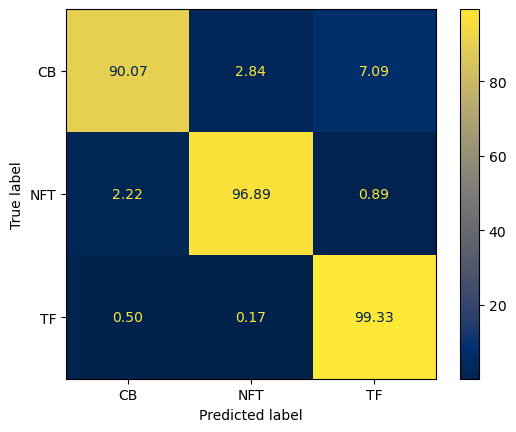

In [17]:
plot = ConfusionMatrixDisplay(final_cm_t,
                              display_labels=['CB','NFT','TF'])
plot.plot(cmap='cividis', values_format='.2f')         
plt.show()

In [29]:
model = loaded_model
# Confusion matrix across 10 folds, WITH thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

Macro avg F1  95.34125434461464
Macro avg F1 std  2.34880939204109
--------------------------
Macro avg precision 95.5265528164053
Macro avg precision std 2.7969517394227177
--------------------------
Macro avg recall  95.34223965514876
Macro avg recall std 2.5749438225075414


In [30]:
model = loaded_model
# Confusion matrix across 10 folds, WITH NO thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reports])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reports])*100)

Macro avg F1  94.10945973618848
Macro avg F1 std  2.887306352363017
--------------------------
Macro avg precision 95.53326807033152
Macro avg precision std 1.9637282763148058
--------------------------
Macro avg recall  93.03483287515236
Macro avg recall std 4.05865234105943


Plotting feature importance

In [20]:
import seaborn as sns

In [21]:
model_rf = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Tau_pipeline/Tuning_parameters/Final/results/dn_random_search.sav')

In [22]:
model_rf.best_params_

{'selector__n_features_to_select': 34,
 'clf__sampling_strategy': 'not majority',
 'clf__random_state': 42,
 'clf__n_estimators': 100,
 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 1,
 'clf__max_samples': None,
 'clf__max_features': 0.2,
 'clf__max_depth': None,
 'clf__class_weight': 'balanced'}

In [23]:
#With feature selection
rf_result = model_rf.best_estimator_.named_steps['selector'].get_support(indices=True)
rf_result
rf_result_f = [dn_data.c2_X_train.columns[i] for i in rf_result]
# (rf_result_f)
importance = model_rf.best_estimator_.named_steps['clf'].feature_importances_
f_importance = pd.DataFrame(data={'features':rf_result_f,'importance':importance})
f_importance = f_importance.sort_values(by=['importance'],ascending=False)

In [24]:
f_importance_subset = f_importance[0:11]
features = [i.replace('ROI: 0.25 µm per pixel: ','') for i in f_importance_subset['features']]
f_importance_subset = f_importance_subset.copy()
f_importance_subset.loc[:,'features'] = features
f_importance_subset = f_importance_subset.rename(columns={'features':'Feature',
                                    'importance':'Importance'})

In [25]:
f_importance_subset

,Feature,Importance
0,Area µm^2,0.216869
4,Min diameter µm,0.207962
3,Max diameter µm,0.058139
2,Length µm,0.056409
19,DAB: Haralick Sum entropy (F7),0.040231
7,Blue: Min,0.037857
17,DAB: Haralick Inverse difference moment (F4),0.025756
20,DAB: Max,0.024155
5,Blue: Mean,0.022950
33,Solidity,0.022746


<Axes: xlabel='Importance', ylabel='Feature'>

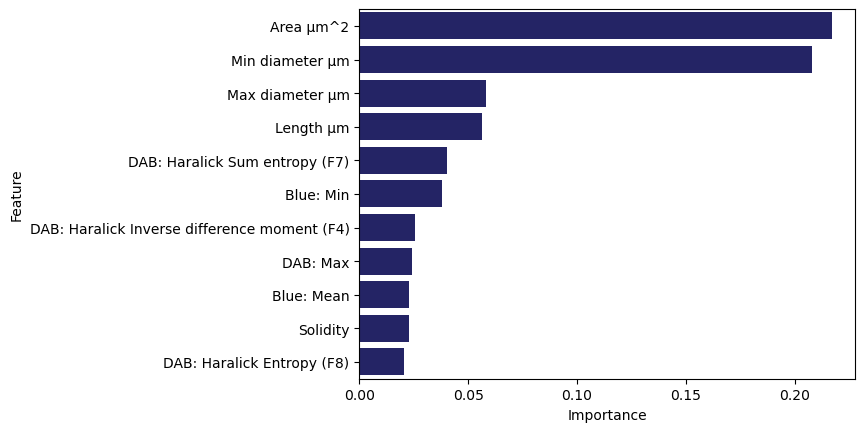

In [26]:
sns.barplot(data=f_importance_subset,
            y="Feature",
            x="Importance",
            color='midnightblue')

In [27]:
keys = ['split0_test_PR_AUC',
        'split1_test_PR_AUC',
        'split2_test_PR_AUC',
        'split3_test_PR_AUC',
        'split4_test_PR_AUC',
        'split5_test_PR_AUC',
        'split6_test_PR_AUC',
        'split7_test_PR_AUC',
        'split8_test_PR_AUC',
        'split9_test_PR_AUC']
pr_val = []
for i in keys:
    pr_val.append(model_rf.cv_results_[i][model_rf.best_index_])

In [28]:
print(model_rf.cv_results_['mean_test_PR_AUC'][model_rf.best_index_]*100)
print('mean pr:', mean(pr_val)*100)
print('std pr:', np.std(pr_val)*100)

97.96589612447606
mean pr: 97.96589612447606
std pr: 1.6311468228215578
